In [ ]:
%pip install pandas
%pip install boto3
%pip install psycopg2
%pip install sqlalchemy
%pip install dotenv


%pip matplotlib
%pip plotly
%pip seaborn 


# Run this cell to install these packages
# !pip install pandas boto3 sqlalchemy python-dotenv

In [1]:
# Import dependencies
import boto3
import os
import pandas as pd
from sqlalchemy import create_engine, text
import psycopg2
from io import StringIO

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import plotly.express as px
import plotly.graph_objects as go


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors





#pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

sns.set(style="whitegrid")

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Load environment variables from .env file
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

True

# <h2 align="center">Data Input</h2>


### Define a Function to Query & Display Results

In [2]:
# Create a function to fetch data from the database
def get_db_connection():
    db_url = (
        f"postgresql://{os.environ['DB_USER']}:{os.environ['DB_PASSWORD']}@"
        f"{os.environ['DB_HOST']}:{os.environ['DB_PORT']}/{os.environ['DB_NAME']}"
    )
    return create_engine(db_url)

# Instantiate the database connection
engine = get_db_connection()


# Define query to fetch data from each table
query_clinics = "SELECT * FROM clinics;"
query_patients = "SELECT * FROM patients;"
query_sessions = "SELECT * FROM sessions;"
query_feedback = "SELECT * FROM feedback;"
query_dropout_flags = "SELECT * FROM dropout_flags;"
query_interventions = "SELECT * FROM interventions;"

# Load data from each table into a DataFrame
clinics_df = pd.read_sql(query_clinics, engine)
patients_df = pd.read_sql(query_patients, engine)
sessions_df = pd.read_sql(query_sessions, engine)
feedback_df = pd.read_sql(query_feedback, engine)
dropout_flags_df = pd.read_sql(query_dropout_flags, engine)
interventions_df = pd.read_sql(query_interventions, engine)

#### Display Data

In [ ]:
# Display the first few rows of each DataFrame
clinics_df.head(2)

In [ ]:
patients_df.head(2)

In [ ]:
sessions_df.head(2)

In [ ]:
feedback_df.head(2)

In [ ]:
dropout_flags_df.head(2)

In [ ]:
interventions_df.head()

## EDA EXPLORATORY DATA ANALYSIS

- Step - 1 = Data Cleaning
- Step - 2 = Data Transformation
- Step - 3 = Data Distribution
- Step - 4 = Correlation Analysis
- Step - 5 = Drop Out Analysis (Step Specifically Tailored to Domain, Health for this case)

### Step 1 - Data Cleaning
    - Step 1a - Identifying missing values
    - Step 1b - Handling missing values
    - Step 1c - Check for duplicates

**PATIENTS DATA**

In [ ]:
patients_df.head()  # Display the first few rows to verify changes

In [ ]:
patients_df.info()

In [ ]:
patients_df.describe()

In [ ]:
# Check for missing values
patients_df.isnull().sum()

In [ ]:
# Check for missing values as percentages
missing_percent = patients_df.isnull().mean() * 100
print(missing_percent)

In [ ]:
# Missing values in descending order (only if > 0%)
missing_percent = (patients_df.isnull().mean() * 100).sort_values(ascending=False)
missing_percent = missing_percent[missing_percent > 0]
print(missing_percent)

#### Observation:
The `chronic_cond` column in the Patient dataset with missing values of about `61%`, shows that there is a need to make a decision `(shred the data or seek alternative)`

*Considerations*:
- Is the column a numeric or categorical data.
    - NOTE (Applying `measures of central tendency`) 

    a.`numeric` data; fill up with either *mean* (to use mean be sure the average value does not full in an outlier, incase of outlier, use median) or *median* (when data points are odd or even numbers, pick the middle number), while

    b. `categorical` data fill up with mode (filling up with the most frequent data point). 

In [3]:
# Data point is Categorical hence fill with the mode
patients_df['chronic_cond'] = patients_df['chronic_cond'].fillna(patients_df['chronic_cond'].mode()[0])  # Fill NaN with mode, note ensure to use the value 0, it shows its an index

In [ ]:
patients_df['chronic_cond'].isnull().sum()  # Check if there are still NaN values

In [ ]:
patients_df.head(2)

#### Check for duplicates and handle it

In [ ]:
patients_df[patients_df.duplicated()]

#### Observation:
- No duplicates in patients dataset

**SESSIONS DATA**

In [ ]:
sessions_df.head(2)

In [ ]:
sessions_df.info()

In [ ]:
sessions_df.describe()

In [ ]:
# Check for missing values
sessions_df.isnull().mean() * 100

#### Observation
- Sessions_df dataset does not contain missing values

In [ ]:
# Check for duplicates
sessions_df[sessions_df.duplicated()]

#### Observation
- Sessions_df does not contain duplicates

### CLINICS DATASET

In [ ]:
clinics_df.head()

In [ ]:
clinics_df.info()

In [ ]:
clinics_df.describe()

In [ ]:
# check for missing values
clinics_df.isnull().mean() * 100

#### Observation
- No missing values

In [ ]:
### Check for duplicates
clinics_df[clinics_df.duplicated()]

#### Observation
- Clinics dataset does not contain duplicates

### FEEDBACK DATASET

In [ ]:
feedback_df.head()

In [ ]:
feedback_df.info()

In [ ]:
feedback_df.describe()

In [ ]:
# Check for missing values
feedback_df.isnull().mean() * 100

#### Observation
- Feedback dataset does not contain missing values

In [ ]:
# Check for duplicates
feedback_df[feedback_df.duplicated()]

#### Observation
- Feedback dataset does not contain duplicates

### DROPOUTS DATASET

In [ ]:
dropout_flags_df.head()

In [ ]:
dropout_flags_df.info()

In [ ]:
dropout_flags_df.describe()

In [ ]:
### Check for missing values
dropout_flags_df.isnull().mean() * 100

#### Observation
- The dropout week column contains about `98% missing` values, we can easily make the decision to drop the column

In [4]:
# Modify in place, don't reassign
dropout_flags_df.drop(columns=['dropout_week'], inplace=True)
dropout_flags_df.head(2)

,patient_id,dropout
0,1,False
1,2,False


In [ ]:
# Check for duplicates
dropout_flags_df[dropout_flags_df.duplicated()]

### INTERVENTIONS DATASET

In [ ]:
interventions_df.head()

In [ ]:
interventions_df.info()

In [ ]:
interventions_df.describe()

In [ ]:
# Check for missing values
interventions_df.isnull().mean() * 100

In [ ]:
# Check for duplicates
interventions_df[interventions_df.duplicated()]

### Step 2 Data Transformation

Ensuring all columns are put in the right condition

- Handle inconsistent data type
- 

### PATIENTS DATASET

In [ ]:
patients_df.head(2)

In [5]:
# Transform date columns to datetype
patients_df['signup_date'] = pd.to_datetime(patients_df['signup_date'])
patients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   patient_id       5000 non-null   int64         
 1   age              5000 non-null   int64         
 2   gender           5000 non-null   object        
 3   bmi              5000 non-null   float64       
 4   smoker           5000 non-null   bool          
 5   chronic_cond     5000 non-null   object        
 6   injury_type      5000 non-null   object        
 7   signup_date      5000 non-null   datetime64[ns]
 8   referral_source  5000 non-null   object        
 9   consent          5000 non-null   bool          
 10  clinic_id        5000 non-null   int64         
 11  insurance_type   5000 non-null   object        
dtypes: bool(2), datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 400.5+ KB


In [6]:
# # Convert and place age column into categories of ages
# bins, categories
bin = [0, 18, 30, 35, 40, 55, 75, np.inf]  # 8 bin edges
labels = ['0-18', '19-30', '31-35', '36-40', '41-55', '56-75', '76+']  # 7 labels
patients_df['age_group'] = pd.cut(patients_df['age'], bins=bin, labels=labels)
patients_df.head(2)

,patient_id,age,gender,bmi,smoker,chronic_cond,injury_type,signup_date,referral_source,consent,clinic_id,insurance_type,age_group
0,1,29,Male,23.9,False,Diabetes,Knee,2025-04-27 00:12:44.286283,Insurance,True,6,Public,19-30
1,2,68,Female,31.7,True,Diabetes,Shoulder,2024-11-28 00:12:44.286283,Insurance,False,3,Public,56-75


In [7]:
# Gender Binary
patients_df['gender_binary'] = patients_df['gender'].map({'Male': 0, 'Female': 1})

In [8]:
 # Smoker as Binary
patients_df['smoker'] = patients_df['smoker'].astype(int)

In [9]:
# Consent as Binary
patients_df['consent'] = patients_df['consent'].astype(int)

In [ ]:
patients_df.head(2)

### SESSIONS DATASET

In [ ]:
sessions_df.head()

In [10]:
sessions_df['date'] = pd.to_datetime(sessions_df['date'])
sessions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70236 entries, 0 to 70235
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   session_id         70236 non-null  object        
 1   patient_id         70236 non-null  int64         
 2   date               70236 non-null  datetime64[ns]
 3   week               70236 non-null  int64         
 4   duration           70236 non-null  int64         
 5   pain_level         70236 non-null  int64         
 6   exercise_type      70236 non-null  object        
 7   home_adherence_pc  70236 non-null  int64         
 8   satisfaction       70236 non-null  int64         
 9   therapist_id       70236 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(2)
memory usage: 5.4+ MB


### CLINICS DATASET

In [ ]:
clinics_df.head()

### FEEDDBACK DATASET

In [ ]:
feedback_df.head()

### DROPOUT_FLAGS DATASET

In [ ]:
dropout_flags_df.head()

In [11]:
dropout_flags_df['dropout'] = dropout_flags_df['dropout'].astype(int)

In [ ]:
dropout_flags_df.head()

### INTERVENTIONS DATASET

In [ ]:
interventions_df.head()

In [12]:
interventions_df['responded'] = interventions_df['responded'].astype(int)

### Data Distribution

Using visualization plots to see and note the coverage of the data
This will include univariate analysis, outlier detection, bivariate analysis and in some cases multivariate analysis.

### PATIENTS DATASET

In [ ]:
# Get the number of patients per clinic

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(patients_df['age'], kde=True)
plt.title('Distribution of Age', fontsize=16, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.xlabel('Age', fontsize=12, fontweight='bold')
plt.show()

#### Observation;
- Age of the patients spans from age 18 to 100 years old. There are 
- The ages are evenly spread hence its a `normal distribution`
- This shows that therapy is for all age groups etc.


In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(patients_df['bmi'], kde=True)
plt.title('BMI Distribution', fontsize=16, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.xlabel('BMI', fontsize=12, fontweight='bold')
plt.show()

In [ ]:
# Gender Distribution
plt.figure(figsize=(15, 8))
sns.countplot(patients_df, x = 'gender')
plt.title('Gender Distribution', fontsize=16, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.xlabel('Gender', fontsize=12, fontweight='bold')
plt.show()

In [ ]:
# Smoker Distribution
plt.figure(figsize=(15, 8))
sns.countplot(patients_df, x = 'smoker')
plt.title('Smoker Distribution', fontsize=16, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.xlabel('Smoker', fontsize=12, fontweight='bold')
plt.show()

In [ ]:
# Chronic Condition Distribution
plt.figure(figsize=(15, 8))
order = patients_df['chronic_cond'].value_counts().index
sns.countplot(patients_df, y = 'chronic_cond', order=order)
plt.title('Chronic Condition Distribution', fontsize=16, fontweight='bold')
plt.ylabel('Chronic Condition', fontsize=12, fontweight='bold')
plt.xlabel('Frequency', fontsize=12, fontweight='bold')
plt.show()

In [ ]:
# Injury Type Distribution
plt.figure(figsize=(15, 8))
order = patients_df['injury_type'].value_counts().index
sns.countplot(data=patients_df, y='injury_type', order=order)
plt.title('Injury Type Distribution', fontsize=16, fontweight='bold')
plt.ylabel('Injury Type', fontsize=12, fontweight='bold')
plt.xlabel('Frequency', fontsize=12, fontweight='bold')

In [ ]:
# Insurance Type Distribution
plt.figure(figsize=(15, 8))
order = patients_df['insurance_type'].value_counts().index
sns.countplot(data=patients_df, y='insurance_type', order=order)
plt.title('Insurance Type Distribution', fontsize=16, fontweight='bold')
plt.ylabel('Insurance Type', fontsize=12, fontweight='bold')
plt.xlabel('Frequency', fontsize=12, fontweight='bold')

In [ ]:
# Age by Gender
plt.figure(figsize=(15, 8))
sns.boxplot(x='gender', y='age', data=patients_df)
plt.title('Age by Gender', fontsize=16, fontweight='bold')
plt.ylabel('Age', fontsize=12, fontweight='bold')
plt.xlabel('Gender', fontsize=12, fontweight='bold')
plt.show()

In [ ]:
# BMI by Smoker
plt.figure(figsize=(15, 8))
sns.boxplot(x='smoker', y='bmi', data=patients_df)
plt.title('BMI by Smoker', fontsize=16, fontweight='bold')
plt.ylabel('BMI', fontsize=12, fontweight='bold')
plt.xlabel('Smoker', fontsize=12, fontweight='bold')
plt.show()

In [ ]:
# Age by Injury Type
plt.figure(figsize=(15, 8))
sns.boxplot(x='injury_type', y='age', data=patients_df)
plt.title('Age by Injury Type', fontsize=16, fontweight='bold')
plt.ylabel('Age', fontsize=12, fontweight='bold')
plt.xlabel('Injury Type', fontsize=12, fontweight='bold')
plt.show()

In [ ]:
# Gender vs Smoker
pd.crosstab(patients_df['gender'], patients_df['smoker']).plot(kind='bar', stacked=True,  figsize=(15, 8), ax=plt.gca())
plt.title('Gender vs Smoker', fontsize=16, fontweight='bold')
plt.ylabel('Frequency Count', fontsize=12, fontweight='bold')
plt.xlabel('Gender/Smoker', fontsize=12, fontweight='bold')
plt.show()

In [ ]:
# Injury Type vs Insurance Type (sorted descending by total count)
ct = pd.crosstab(patients_df['injury_type'], patients_df['insurance_type'])
ct = ct.loc[ct.sum(axis=1).sort_values(ascending=False).index]  # sort rows by total count descending

ct.plot(kind='bar', stacked=True, figsize=(15, 8), ax=plt.gca())
plt.title('Injury Type vs Insurance Type', fontsize=16, fontweight='bold')
plt.ylabel('Frequency Count', fontsize=12, fontweight='bold')
plt.xlabel('Injury Type/Insurance Type', fontsize=12, fontweight='bold')
plt.show()

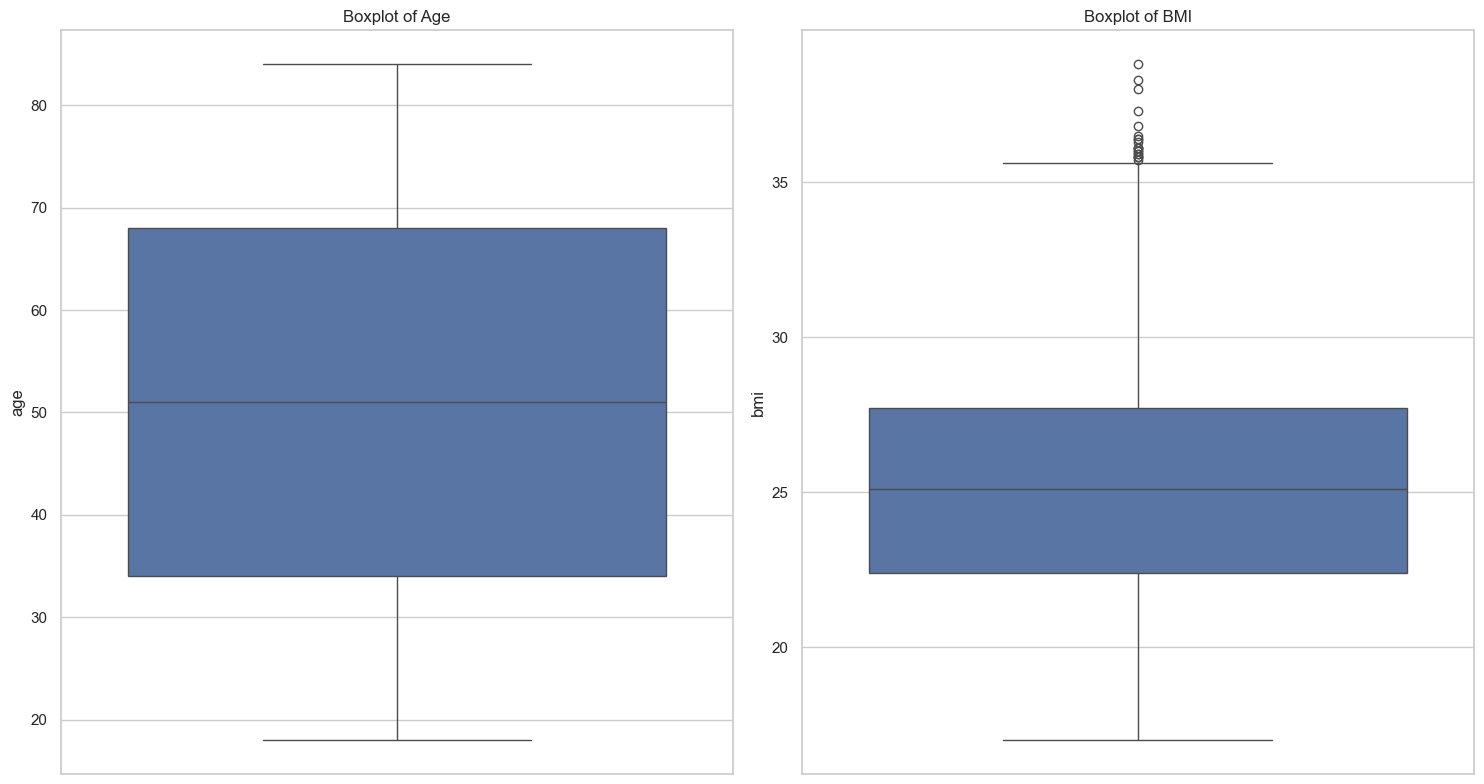

In [13]:
# Outlier Detection Using Boxplots
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
sns.boxplot(y=patients_df['age'], ax=axes[0])
axes[0].set_title('Boxplot of Age')
sns.boxplot(y=patients_df['bmi'], ax=axes[1])
axes[1].set_title('Boxplot of BMI')
plt.tight_layout()
plt.show()

In [14]:
#  Capping Outliers (Using the IQR Method)
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower, upper)

In [15]:
# Apply capping
patients_df['age_capped'] = cap_outliers(patients_df['age'])
patients_df['bmi_capped'] = cap_outliers(patients_df['bmi'])

In [ ]:
# Compare before and after capping
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
sns.boxplot(y=patients_df['age'], ax=axes[0,0])
axes[0,0].set_title('Original Age')
sns.boxplot(y=patients_df['age_capped'], ax=axes[0,1])
axes[0,1].set_title('Capped Age')
sns.boxplot(y=patients_df['bmi'], ax=axes[1,0])
axes[1,0].set_title('Original BMI')
sns.boxplot(y=patients_df['bmi_capped'], ax=axes[1,1])
axes[1,1].set_title('Capped BMI')
plt.tight_layout()
plt.show()

In [ ]:
# Select only numeric columns first
numeric_df = patients_df.select_dtypes(include=["number"])

# Correlation matrix
plt.figure(figsize=(15, 8))
corr = numeric_df.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix', fontsize=16, fontweight='bold')
plt.show()

In [ ]:
# Correlation matrix only for numeric columns
plt.figure(figsize=(15, 8))
numeric_df = patients_df.select_dtypes(include=["number"])
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix", fontsize=16, fontweight="bold")
plt.show()

### SESSIONS DATASET

In [18]:
# Numerical variables
num_cols = ['duration', 'pain_level', 'home_adherence_pc', 'satisfaction']

# Summary statistics
print(sessions_df[num_cols].describe())

           duration    pain_level  home_adherence_pc  satisfaction
count  70236.000000  70236.000000       70236.000000  70236.000000
mean      39.511134      1.982317          69.333775      6.490831
std       11.516467      1.484108          14.846721      1.236411
min       20.000000      1.000000           0.000000      2.000000
25%       30.000000      1.000000          59.000000      6.000000
50%       40.000000      1.000000          69.000000      6.000000
75%       49.000000      3.000000          80.000000      7.000000
max       59.000000      8.000000         100.000000     10.000000


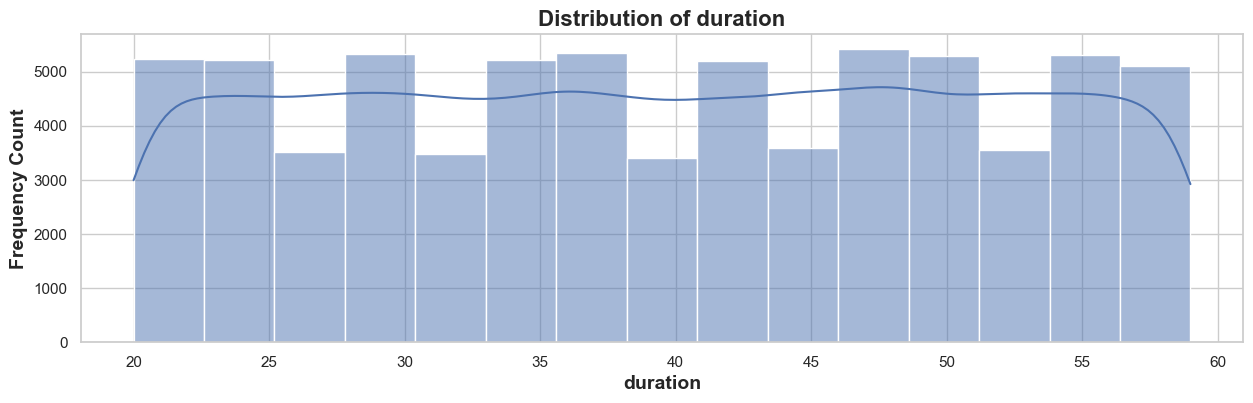

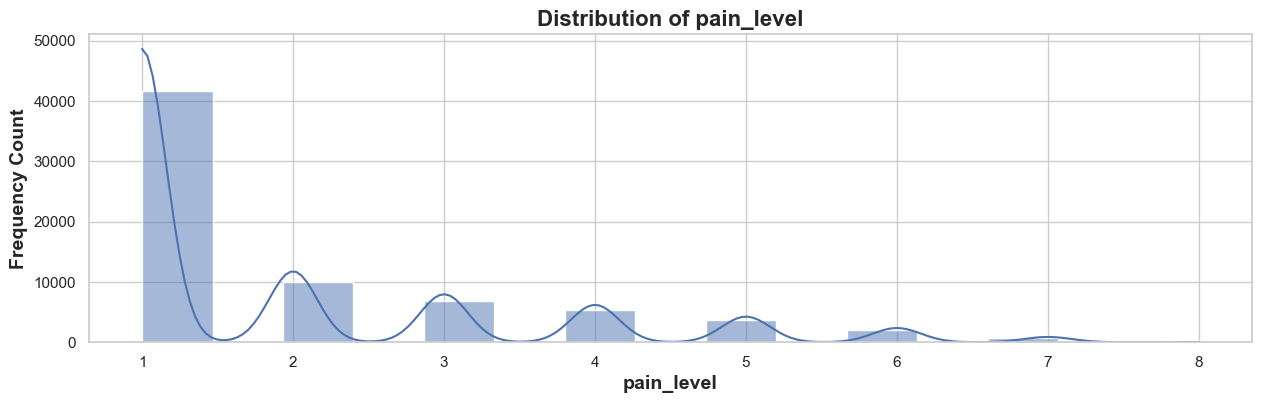

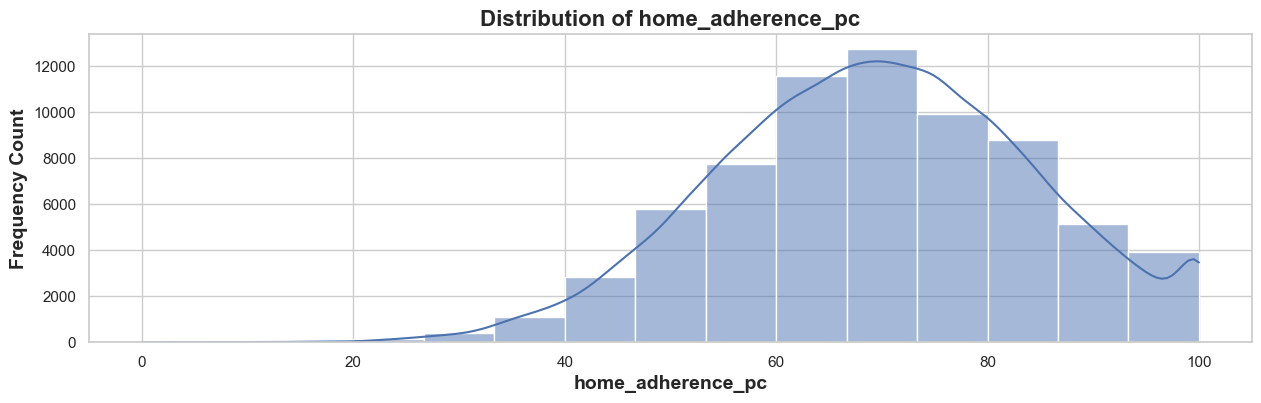

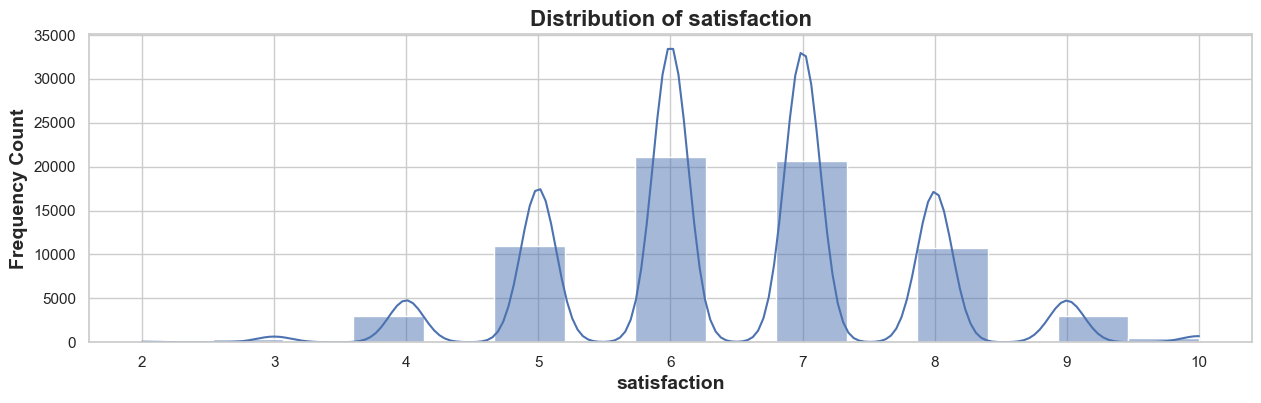

In [19]:
for col in num_cols:
    plt.figure(figsize=(15,4))
    sns.histplot(sessions_df[col], kde=True, bins=15)
    plt.title(f'Distribution of {col}', fontsize=16, fontweight='bold')
    plt.ylabel(f'Frequency Count', fontsize=14, fontweight='bold')
    plt.xlabel(f'{col}', fontsize=14, fontweight='bold')
    plt.show()

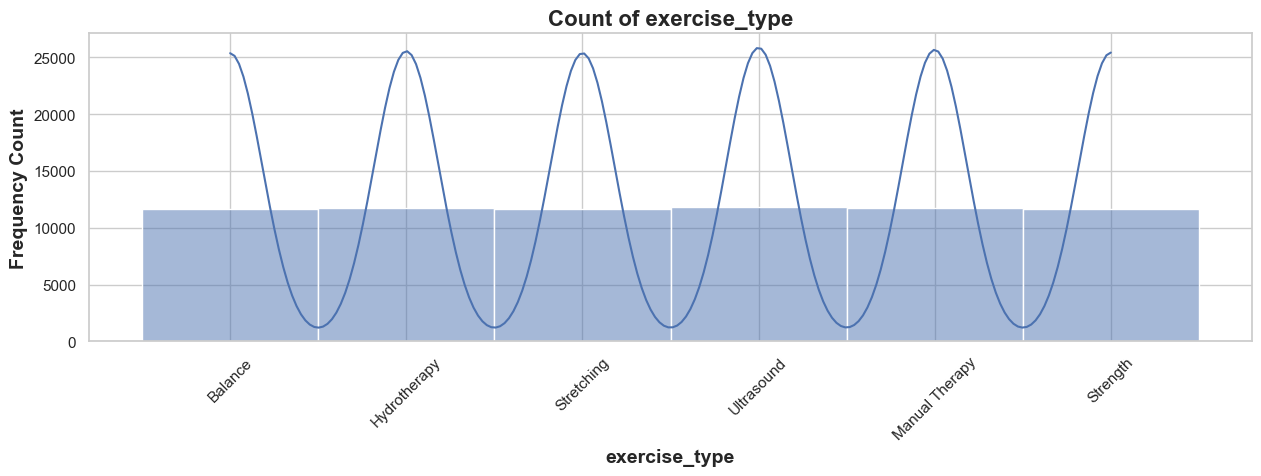

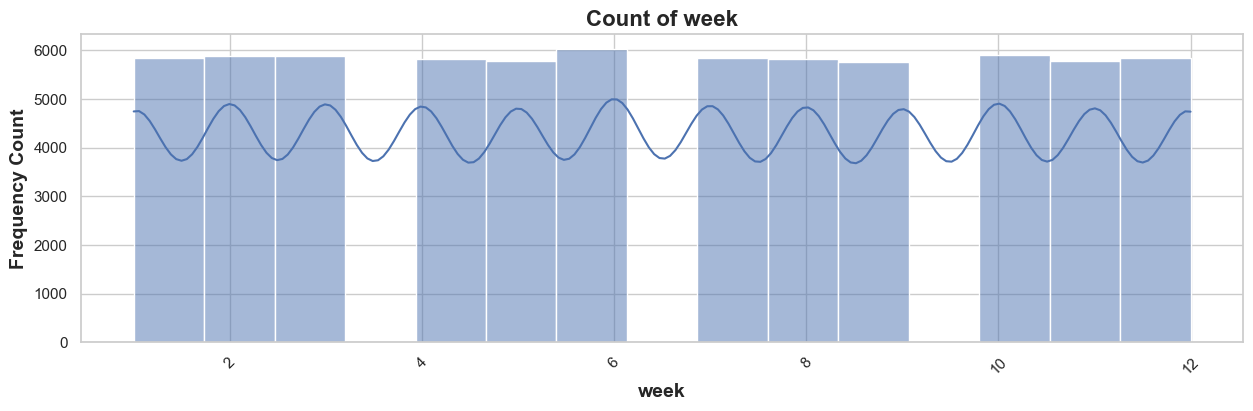

In [20]:
# Categorical Variables
cat_cols = ['exercise_type', 'week']
for col in cat_cols:
    plt.figure(figsize=(15,4))
    sns.histplot(sessions_df[col], kde=True, bins=15)
    plt.title(f'Count of {col}', fontsize=16, fontweight='bold')
    plt.ylabel(f'Frequency Count', fontsize=14, fontweight='bold')
    plt.xlabel(f'{col}', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    plt.show()

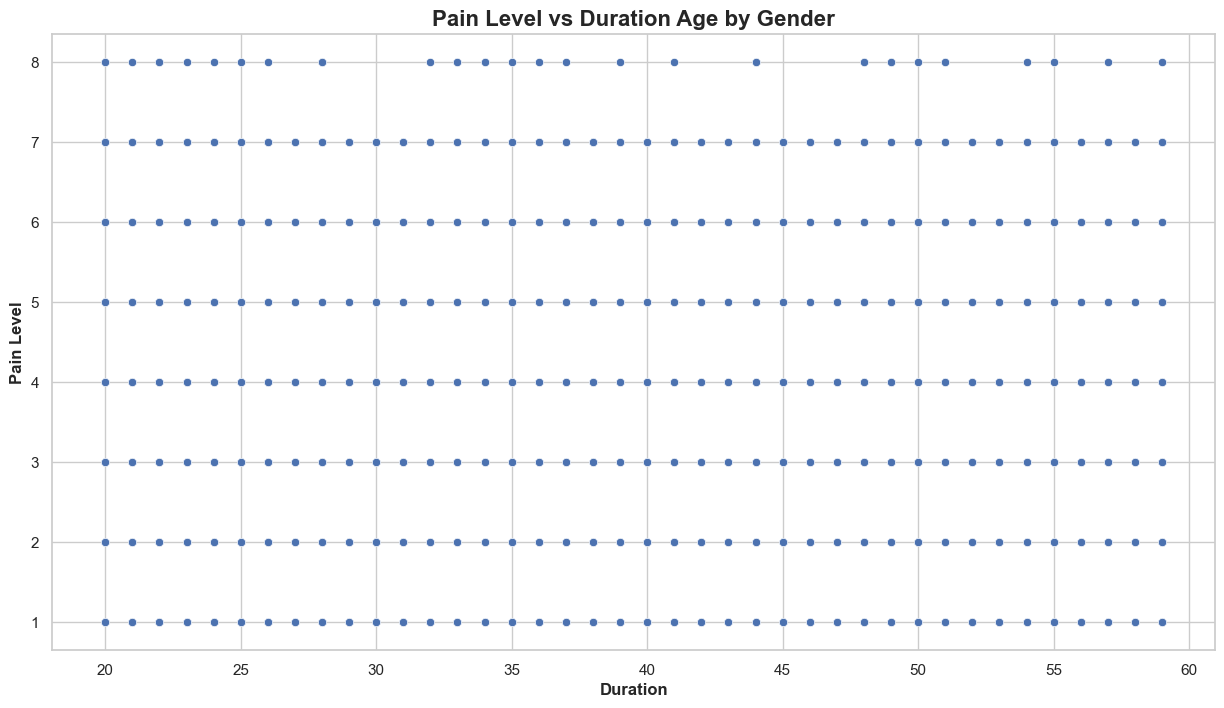

In [21]:
# Pain Level vs Duration
plt.figure(figsize=(15, 8))
sns.scatterplot(x='duration', y='pain_level', data=sessions_df)
plt.title('Pain Level vs Duration Age by Gender', fontsize=16, fontweight='bold')
plt.ylabel('Pain Level', fontsize=12, fontweight='bold')
plt.xlabel('Duration', fontsize=12, fontweight='bold')
plt.show()

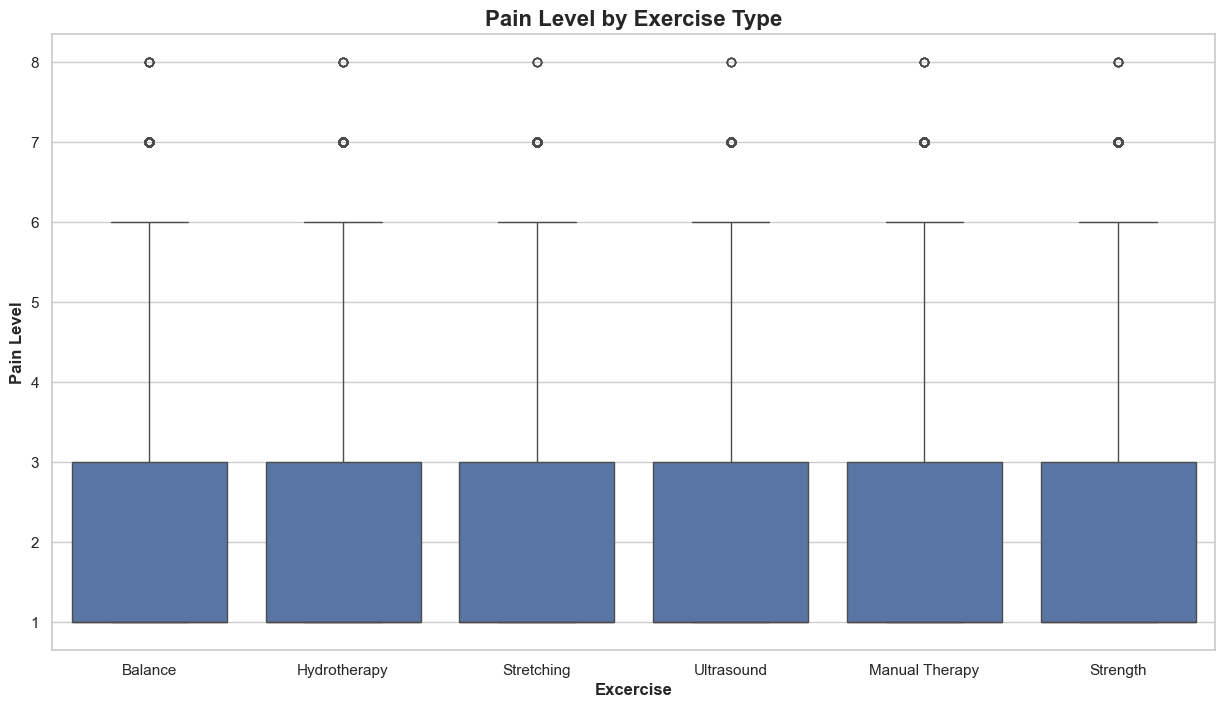

In [22]:
# Pain Level by Exercise Type
plt.figure(figsize=(15, 8))
sns.boxplot(x='exercise_type', y='pain_level', data=sessions_df)
plt.title('Pain Level by Exercise Type', fontsize=16, fontweight='bold')
plt.ylabel('Pain Level', fontsize=12, fontweight='bold')
plt.xlabel('Excercise', fontsize=12, fontweight='bold')
plt.show()

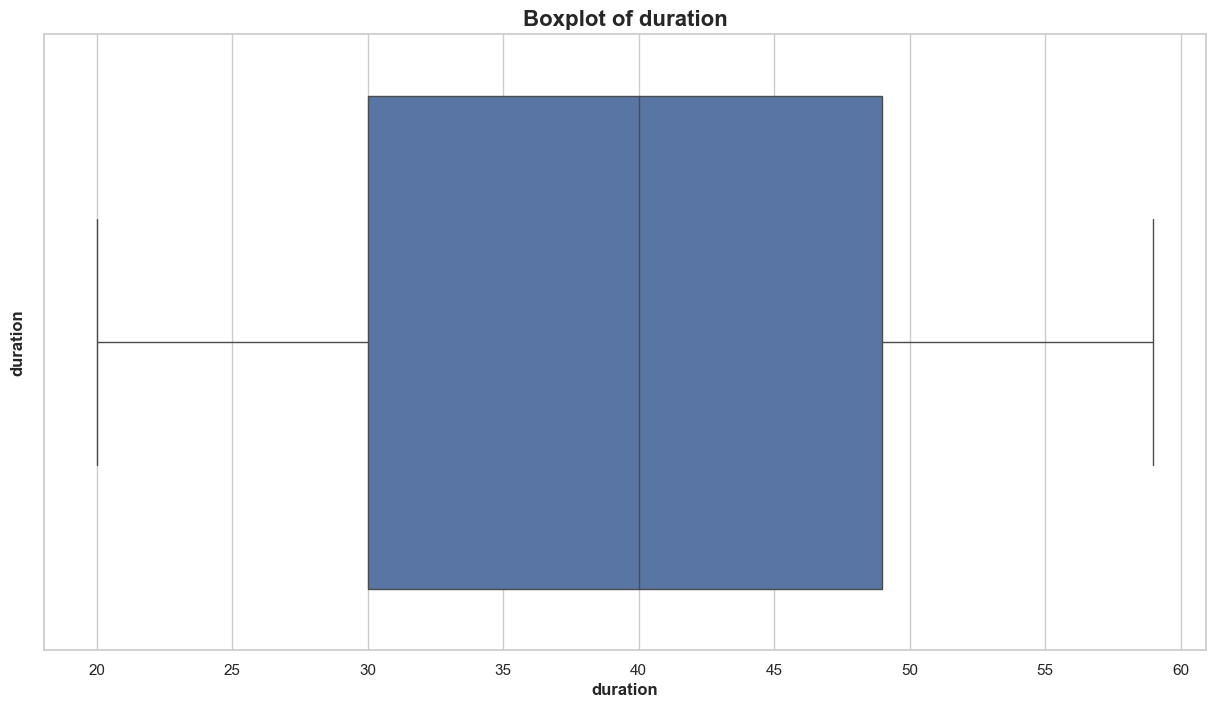

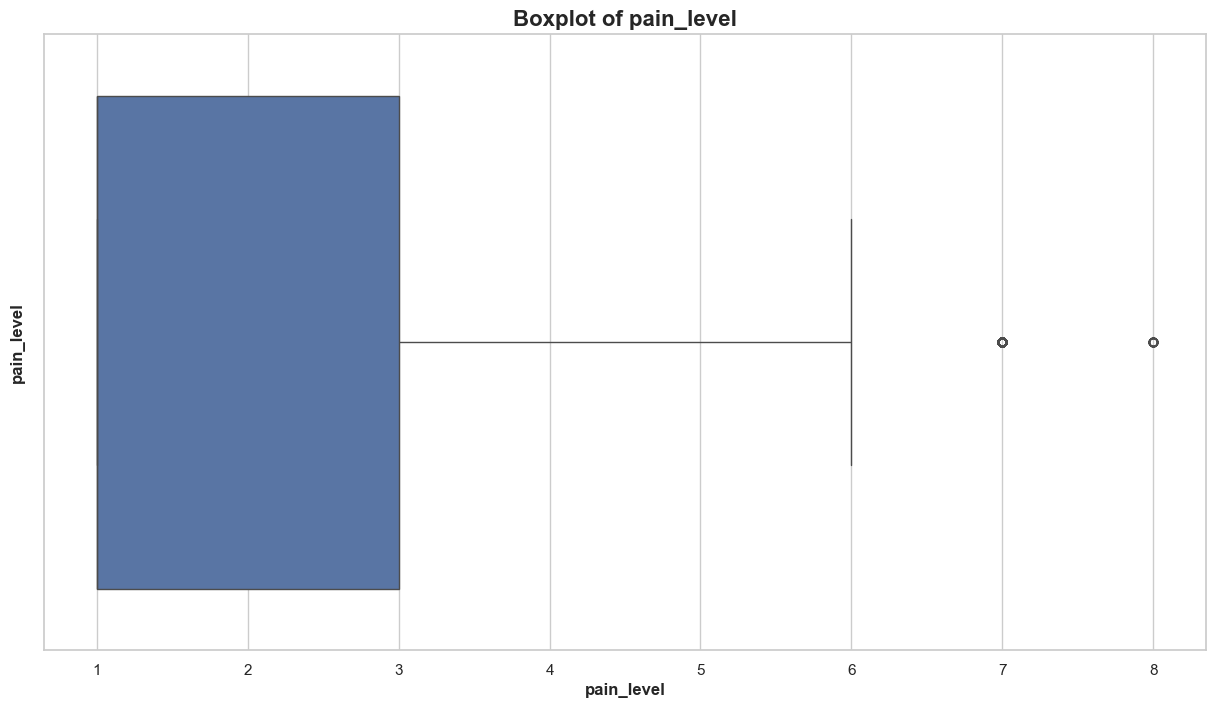

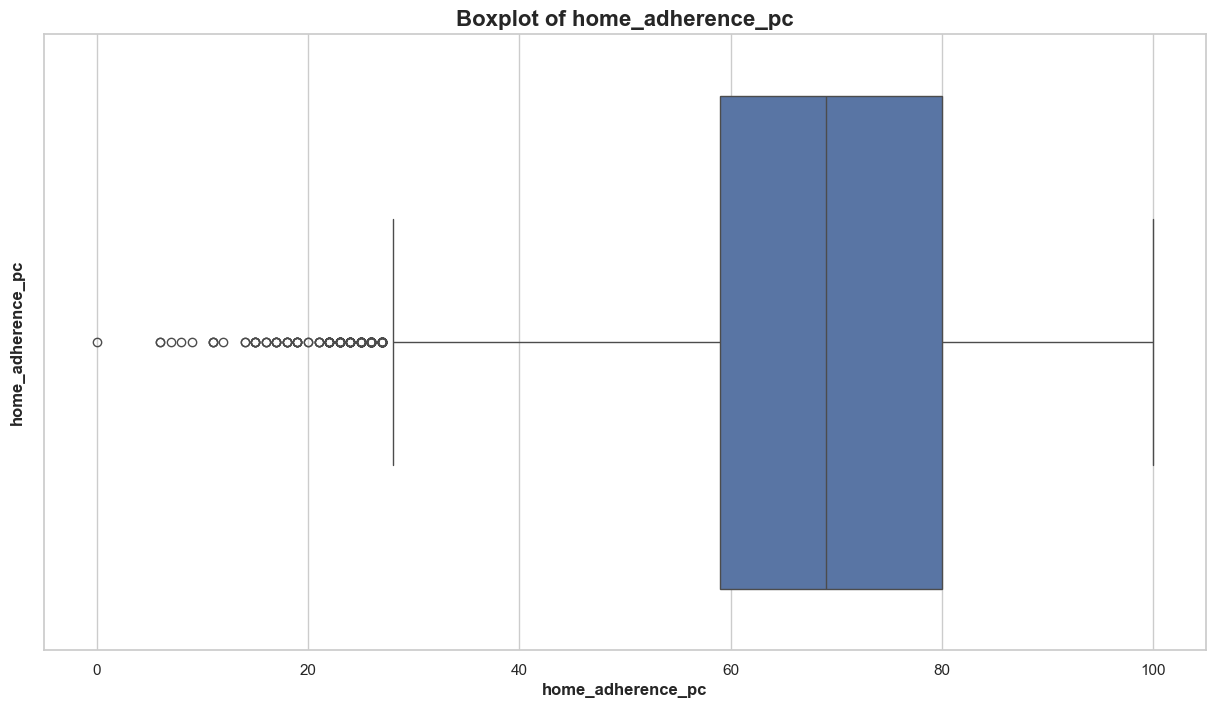

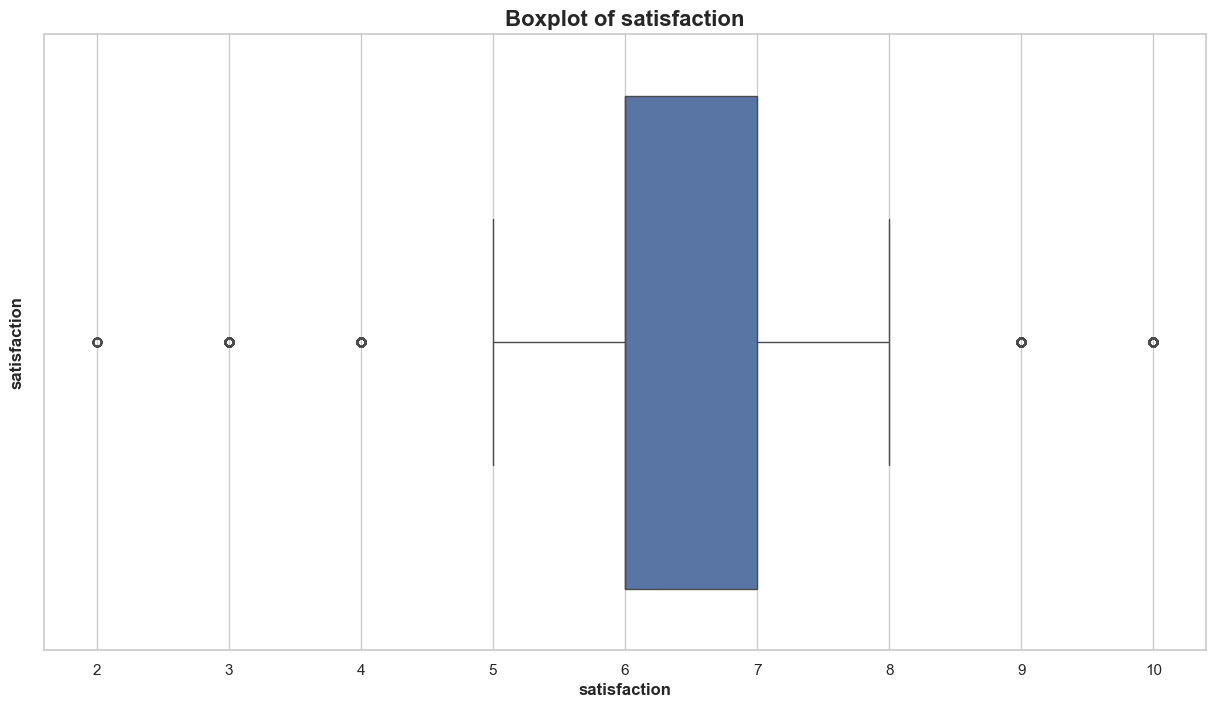

In [23]:
# Outlier Detection using Boxplots
for col in num_cols:
    plt.figure(figsize=(15,8))
    sns.boxplot(x=sessions_df[col], )
    plt.title(f'Boxplot of {col}', fontsize=16, fontweight='bold')
    plt.ylabel(f'{col}', fontsize=12, fontweight='bold')
    plt.xlabel(f'{col}', fontsize=12, fontweight='bold')
    plt.show()

In [24]:
# Detect Outliers (IQR Method)
def detect_outliers(sessions_df, col):
    Q1 = sessions_df[col].quantile(0.25)
    Q3 = sessions_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = sessions_df[(sessions_df[col] < lower) | (sessions_df[col] > upper)]
    print(f"{col}: {len(outliers)} outliers")
    return lower, upper

outlier_bounds = {}
for col in num_cols:
    lower, upper = detect_outliers(sessions_df, col)                                                                                                                                                                                                                     
    outlier_bounds[col] = (lower, upper)

duration: 0 outliers
pain_level: 787 outliers
home_adherence_pc: 187 outliers
satisfaction: 6823 outliers


In [25]:
# Capping/Dealing with Outliers (Capping Outliers at 1.5*IQR)
df_capped = sessions_df.copy()
for col in num_cols:
    lower, upper = outlier_bounds[col]
    df_capped[col] = np.where(df_capped[col] < lower, lower,
                              np.where(df_capped[col] > upper, upper, df_capped[col]))

In [ ]:
for col in num_cols:
    plt.figure(figsize=(15,8))
    sns.boxplot(x=df_capped[col])
    plt.title(f'Boxplot of {col} (After Capping)', fontsize=16, fontweight='bold')
    plt.show()

In [ ]:
# Correlation matrix
plt.figure(figsize=(15, 8))
corr = sessions_df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix', fontsize=16, fontweight='bold')
plt.show()

### CLINICS DATASET

In [ ]:
# Plot distributions
# plt.figure(figsize=(15, 8))
for col in ['capacity', 'staff_count', 'avg_rating']:
    plt.figure(figsize=(15,8))
    sns.histplot(clinics_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

In [ ]:
# Categorical variables
for col in ['city', 'country', 'type', 'speciality']:
    print(f"\nValue counts for {col}:")
    print(clinics_df[col].value_counts())
    plt.figure(figsize=(15,8))
    sns.countplot(y=col, data=clinics_df, order=clinics_df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.show()

In [ ]:
# 4. Bivariate Analysis
# Numerical vs Numerical
plt.figure(figsize=(15,8))
sns.scatterplot(data=clinics_df, x='capacity', y='staff_count')
plt.title('Staff Count vs Capacity')
plt.show()

In [ ]:
# Numerical vs Categorical
plt.figure(figsize=(15,8))
sns.boxplot(x='type', y='avg_rating', data=clinics_df)
plt.title('Average Rating by Clinic Type')
plt.show()

plt.figure(figsize=(15,8))
sns.boxplot(x='country', y='capacity', data=clinics_df)
plt.title('Capacity by Country')
plt.show()

In [ ]:
# 5. Outlier Detection Using Boxplots
for col in ['capacity', 'staff_count', 'avg_rating']:
    plt.figure(figsize=(15,8))
    sns.boxplot(x=clinics_df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [ ]:
# 6. Capping Outliers (IQR Method)
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower, upper)

In [ ]:
for col in ['capacity', 'staff_count', 'avg_rating']:
    clinics_df[f'{col}_capped'] = cap_outliers(clinics_df[col])

In [ ]:
# Visualize after capping
for col in ['capacity', 'staff_count', 'avg_rating']:
    plt.figure(figsize=(15,8))
    sns.boxplot(x=clinics_df[f'{col}_capped'])
    plt.title(f'Boxplot of {col} (After Capping)')
    plt.show()

In [ ]:
# Correlation matrix
corr = clinics_df[['capacity', 'staff_count', 'avg_rating']].corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Patient Distribution per Clinic

# Get the number of patients per clinic

# Count of Patients per Clinic
# Group patients by clinic_id
clinic_counts = patients_df.groupby("clinic_id")["patient_id"].count().reset_index()
clinic_counts.rename(columns={"patient_id": "num_patients"}, inplace=True)
clinic_counts

In [ ]:
# Merge with clinic names for context
clinic_summary = clinic_counts.merge(clinics_df[["clinic_id", "city", "speciality", "avg_rating"]], on="clinic_id")
clinic_summary.sort_values(by="num_patients", ascending=False, inplace=True)
clinic_summary

In [ ]:
# Bar Plot of Patient Distribution
plt.figure(figsize=(15, 8))
sns.barplot(
    data=clinic_summary,
    x="city",
    y="num_patients",
    hue="speciality",
    palette="Set2"
)
plt.title("Number of Patients per Clinic", fontsize=16, fontweight="bold")
plt.ylabel("Patients", fontsize=12, fontweight="bold")
plt.xlabel("Clinic City", fontsize=12, fontweight="bold")
plt.xticks(rotation=45)
plt.legend(title="Speciality")
plt.tight_layout()
plt.show()

In [ ]:
# Pie Chart of Patient Distribution
plt.figure(figsize=(15, 8))
plt.pie(
    clinic_summary["num_patients"],
    labels=clinic_summary["city"],
    autopct="%1.1f%%",
    colors=sns.color_palette("pastel")
)
plt.title("Patient Distribution by Clinic", fontsize=16, fontweight="bold")
plt.show()

### FEEDBACK DATASET

In [ ]:
# Sentiment Score Distribution
plt.figure(figsize=(15,8))
sns.histplot(feedback_df['sentiment'], bins=10, kde=True, color='cornflowerblue')
plt.title("Sentiment Score Distribution", fontsize=16, fontweight="bold")
plt.xlabel("Sentiment", fontsize=12, fontweight="bold")
plt.ylabel("Frequency", fontsize=12, fontweight="bold")
plt.grid(True)
plt.show()

In [ ]:
# Sentiment vs Comments (Bar plot: average sentiment per unique comment text (top N))
top_comments = feedback_df['comments'].value_counts().index[:6]

plt.figure(figsize=(15,8))
sns.boxplot(
    data=feedback_df[feedback_df['comments'].isin(top_comments)],
    x='comments', y='sentiment', palette='Set2'
)
plt.xticks(rotation=45, ha='right')
plt.title("Sentiment Distribution by Comment Text", fontsize=16, fontweight="bold")
plt.ylabel("Sentiment Score", fontsize=12, fontweight="bold")
plt.xlabel("Comment", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

In [ ]:
# Outlier Detection with Box Plot

# Boxplot for outlier detection
plt.figure(figsize=(15, 8))
sns.boxplot(y=feedback_df['sentiment'], color='tomato')
plt.title("Sentiment Score Box Plot", fontsize=16, fontweight="bold")
plt.ylabel("Sentiment", fontsize=12, fontweight="bold")
plt.grid(True)
plt.show()


In [26]:
# Detect Outliers (IQR Method)
# Calculate IQR Boundaries
Q1 = feedback_df['sentiment'].quantile(0.25)
Q3 = feedback_df['sentiment'].quantile(0.75)
IQR = Q3 - Q1

# Set fences (outlier thresholds)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = feedback_df[(feedback_df['sentiment'] < lower_bound) | (feedback_df['sentiment'] > upper_bound)]
print(f"Number of outliers: {outliers.shape[0]}")
display(outliers)

Number of outliers: 0


,feedback_id,session_id,comments,sentiment


In [27]:
# Cap Outliers with IQR
print(f"Lower Bound: {lower_bound:.3f}, Upper Bound: {upper_bound:.3f}")

# Apply capping (clip values to boundary)
feedback_df['sentiment_capped'] = feedback_df['sentiment'].clip(lower=lower_bound, upper=upper_bound)

Lower Bound: -0.813, Upper Bound: 1.355


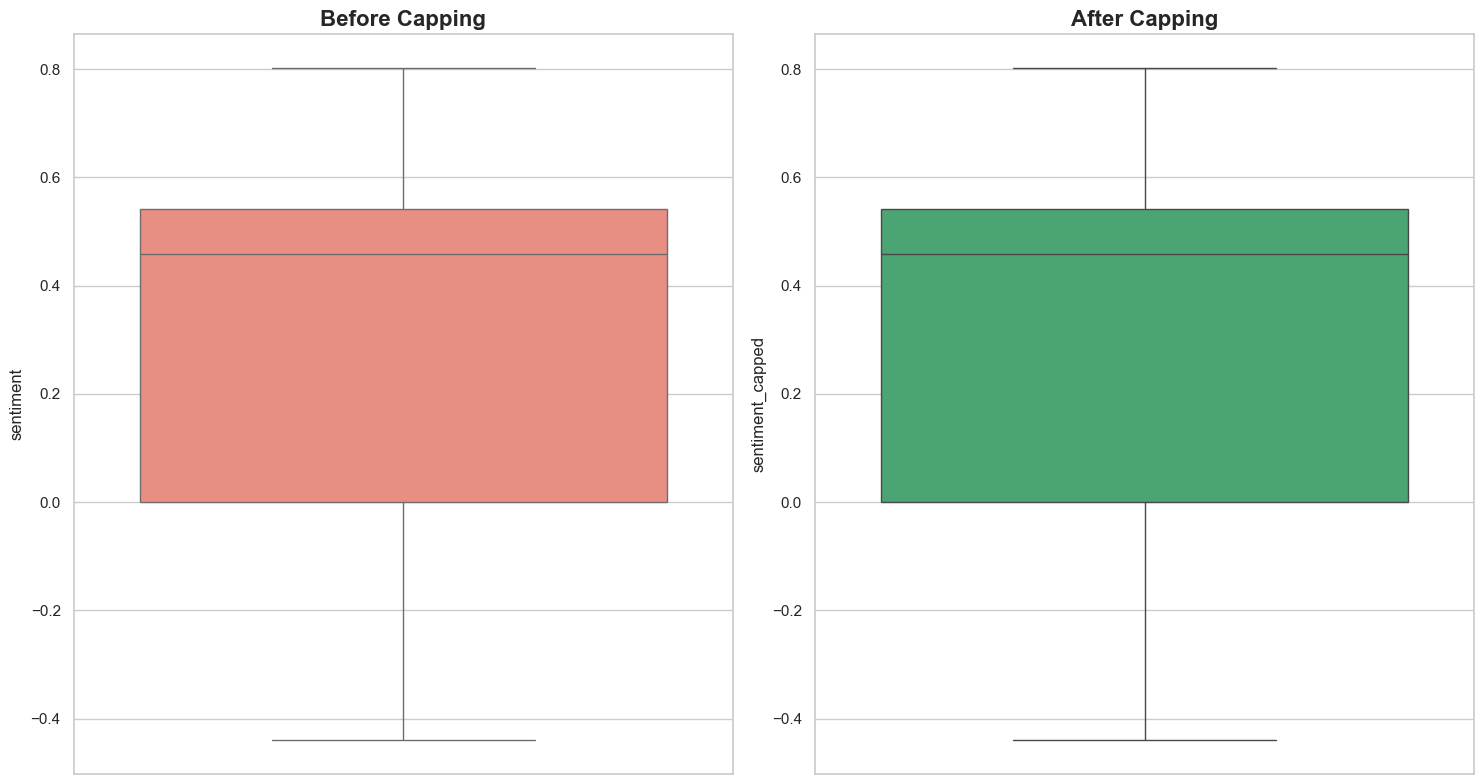

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

sns.boxplot(y=feedback_df['sentiment'], ax=axs[0], color='salmon')
axs[0].set_title("Before Capping", fontsize=16, fontweight="bold")

sns.boxplot(y=feedback_df['sentiment_capped'], ax=axs[1], color='mediumseagreen')
axs[1].set_title("After Capping", fontsize=16, fontweight="bold")

plt.tight_layout()
plt.show()

In [ ]:
# Cap Outliers with Winsorization
# Clip outlier values to boundaries
feedback_df['sentiment_capped'] = feedback_df['sentiment'].clip(lower=lower_bound, upper=upper_bound)

# Visualize capped sentiment
plt.figure(figsize=(15,8))
sns.histplot(feedback_df['sentiment_capped'], bins=10, kde=True, color='mediumseagreen')
plt.title("Sentiment Distribution After Capping", fontsize=16, fontweight="bold")
plt.xlabel("Capped Sentiment", fontsize=12, fontweight="bold")
plt.ylabel("Frequency", fontsize=12, fontweight="bold")
plt.show()

### DROPOUT DATASET

In [ ]:
# Count plot of dropout status
plt.figure(figsize=(15,8))
sns.countplot(x='dropout', data=dropout_flags_df, palette='pastel')
plt.title("Distribution of Dropout Status", fontsize=16, fontweight="bold")
plt.xlabel("Dropout", fontsize=16, fontweight="bold")
plt.ylabel("Count", fontsize=12, fontweight="bold")
plt.grid(True)
plt.show()

In [ ]:
# Outlier Detection — Boxplot (Not Applicable Here)
# Attempt boxplot (no numeric target here, but let's include one for structure)
dropout_flags_df['flag_numeric'] = dropout_flags_df['dropout'].astype(int)

plt.figure(figsize=(15,8))
sns.boxplot(y='flag_numeric', data=dropout_flags_df, color='skyblue')
plt.title("Boxplot of Dropout Flags", fontsize=16, fontweight="bold")
plt.ylabel("Dropout Value (as int)", fontsize=12, fontweight="bold")
plt.grid(True)
plt.show()

In [ ]:
# Check shape first
print(dropout_flags_df.shape) 

In [29]:
# Use np.random.randint to simulate realistic session_count data
dropout_flags_df['session_count'] = np.random.randint(2, 15, size=dropout_flags_df.shape[0])

In [30]:
# Outlier Capping Template (For Future Numeric Features)

# Calculate IQR
Q1 = dropout_flags_df['session_count'].quantile(0.25)
Q3 = dropout_flags_df['session_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap the values
dropout_flags_df['session_count_capped'] = dropout_flags_df['session_count'].clip(lower=lower_bound, upper=upper_bound)

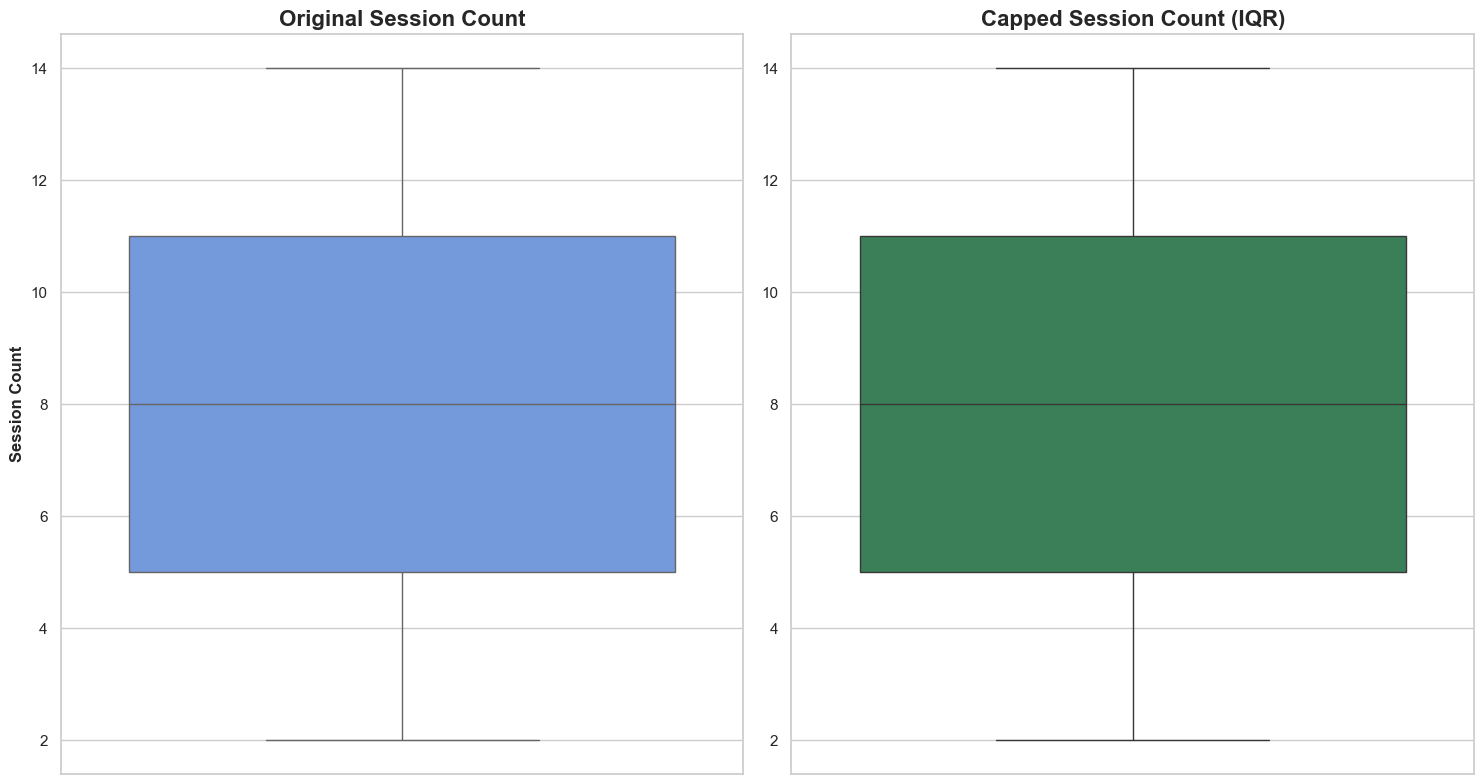

In [31]:
# Side-by-side boxplots
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Original session counts
sns.boxplot(y=dropout_flags_df['session_count'], ax=axs[0], color='cornflowerblue')
axs[0].set_title("Original Session Count", fontsize=16, fontweight="bold")
axs[0].set_ylabel("Session Count",  fontsize=12, fontweight="bold")

# Capped session counts
sns.boxplot(y=dropout_flags_df['session_count_capped'], ax=axs[1], color='seagreen')
axs[1].set_title("Capped Session Count (IQR)", fontsize=16, fontweight="bold")
axs[1].set_ylabel("",  fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

### INTERVENTIONS DATASET

In [ ]:
# Count of Interventions by Channel
plt.figure(figsize=(15,8))
sns.countplot(data=interventions_df, x="channel", order=interventions_df["channel"].value_counts().index, palette="Set2")
plt.title("Frequency of Interventions by Channel", fontsize=16, fontweight="bold")
plt.xlabel("Channel", fontsize=12, fontweight="bold")
plt.ylabel("Count", fontsize=12, fontweight="bold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Distribution of Responses
plt.figure(figsize=(15,8))
sns.countplot(data=interventions_df, x="responded", palette="pastel")
plt.title("Response Distribution", fontsize=16, fontweight="bold")
plt.xlabel("Responded", fontsize=12, fontweight="bold")
plt.ylabel("Count", fontsize=12, fontweight="bold")
plt.show()

In [ ]:
# Channel vs Response Rate
plt.figure(figsize=(15,8))
sns.countplot(data=interventions_df, x="channel", hue="responded", palette="coolwarm")
plt.title("Response Rate by Channel", fontsize=16, fontweight="bold")
plt.xlabel("Channel", fontsize=12, fontweight="bold")
plt.ylabel("Count", fontsize=12, fontweight="bold")
plt.legend(title="Responded")
plt.tight_layout()
plt.show()

In [ ]:
# Message Type vs Response Rate
top_msgs = interventions_df["message"].value_counts().index[:6]
filtered = interventions_df[interventions_df["message"].isin(top_msgs)]

plt.figure(figsize=(15,8))
sns.barplot(data=filtered, x="message", y="responded", estimator=lambda x: sum(x)/len(x), ci=None)
plt.xticks(rotation=45, ha='right')
plt.title("Response Rate by Message", fontsize=16, fontweight="bold")
plt.ylabel("Response Rate", fontsize=12, fontweight="bold")
plt.xlabel("Message", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

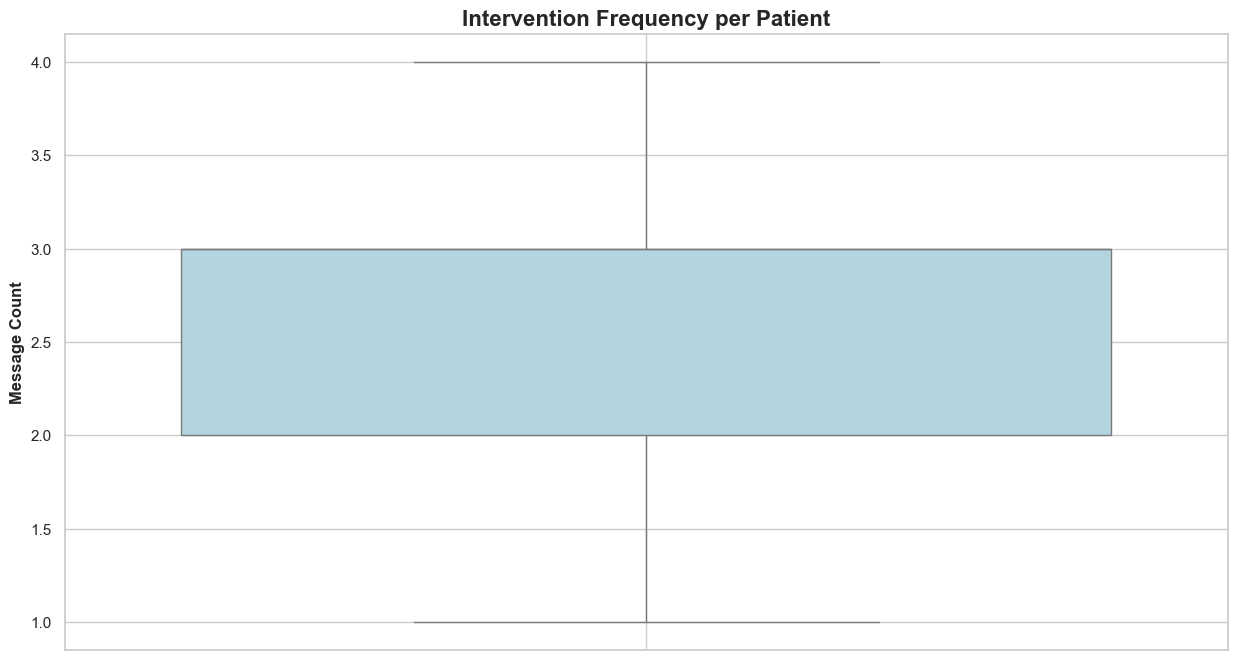

In [32]:
# Outlier Detection with Box Plot (Response Frequency)
# Add frequency per patient
freq_df = interventions_df.groupby("patient_id").size().reset_index(name="msg_count")

plt.figure(figsize=(15,8))
sns.boxplot(y=freq_df["msg_count"], color='lightblue')
plt.title("Intervention Frequency per Patient", fontsize=16, fontweight="bold")
plt.ylabel("Message Count", fontsize=12, fontweight="bold")
plt.grid(True)
plt.show()

In [33]:
# Outlier Capping using IQR
Q1 = freq_df["msg_count"].quantile(0.25)
Q3 = freq_df["msg_count"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap outliers
freq_df["msg_count_capped"] = freq_df["msg_count"].clip(lower=lower_bound, upper=upper_bound)

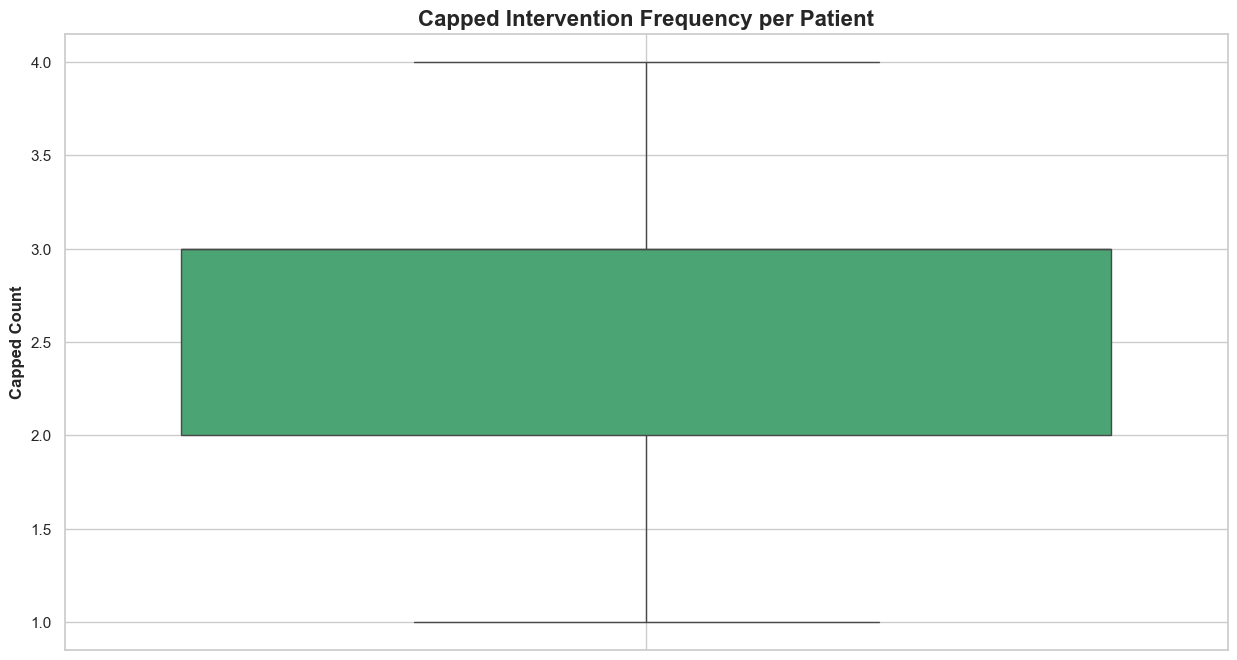

In [34]:
# Visualize After 
plt.figure(figsize=(15,8))
sns.boxplot(y=freq_df["msg_count_capped"], color='mediumseagreen')
plt.title("Capped Intervention Frequency per Patient", fontsize=16, fontweight="bold")
plt.ylabel("Capped Count", fontsize=12, fontweight="bold")
plt.grid(True)
plt.show()

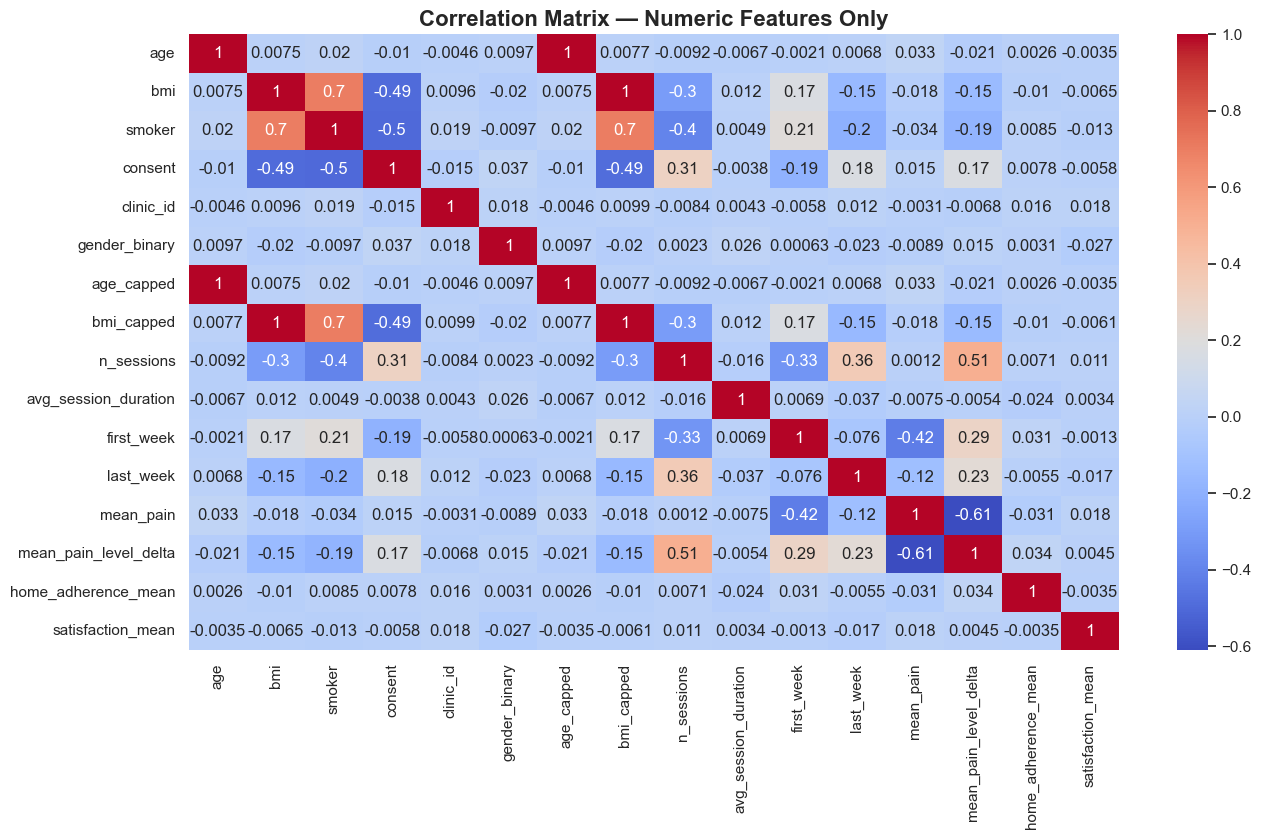

In [47]:
corr = patient_session_df.select_dtypes(include='number').corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix — Numeric Features Only', fontsize=16, fontweight='bold')
plt.show()

In [ ]:
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# PostgreSQL Configuration using SQLAlchemy
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

# Create SQLAlchemy engine
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# Table mapping for CSV files
table_mapping = {
    "clinics.csv": "clinics",
    "dropout_flags.csv": "dropout_flags",
    "feedback.csv": "feedback",
    "sessions.csv": "sessions",
    "interventions.csv": "interventions",
    "patients.csv": "patients"
}

# Function to check if a table exists
def check_table_exists(table_name):
    query = text(f"""
        SELECT EXISTS (
            SELECT FROM information_schema.tables WHERE table_name = '{table_name}'
        );
    """)

    with engine.connect() as conn:
        result = conn.execute(query).fetchone()
    return result[0]

# Function to extract data from PostgreSQL
def extract_data(table_name):
    if check_table_exists(table_name):
        query = text(f"SELECT * FROM {table_name}")

        with engine.connect() as conn:
            df = pd.read_sql(query, conn)
        return df
    else:
        print(f"Table '{table_name}' does not exist. Skipping extraction.")
        return None

# Load data into Pandas DataFrames
dataframes = {}

for csv_file, table_name in table_mapping.items():
    print(f"Extracting data from: {table_name}")
    df = extract_data(table_name)
    
    # Ensure data is extracted
    if df is not None:  
        dataframes[csv_file] = df

# Display extracted DataFrames in Python Script
for csv_file, df in dataframes.items():
    print(f"\n Data Preview for {csv_file}:")
    print(df.head())


In [ ]:
# Cretae Function to get a database connection
def get_db_connection():
    db_url = (
        f"postgresql://{os.environ['DB_USER']}:{os.environ['DB_PASSWORD']}@"
        f"{os.environ['DB_HOST']}:{os.environ['DB_PORT']}/{os.environ['DB_NAME']}"
    )
    return create_engine(db_url)

# Instantiate the database connection
engine = get_db_connection()


# Function to execute a SQL query and return the result as a DataFrame
def execute_query(query):
    with engine.connect() as connection:
        result = connection.execute(text(query))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
    return df

In [ ]:
def run_query(sql):
    try:
        df = pd.read_sql(sql, engine)
        display(df)
    except Exception as e:
        print("Query failed:", e)

#### Example Queries

In [ ]:
# View all clinics
run_query("SELECT * FROM clinics;")

In [ ]:
# View patients at clinic_id = 4
run_query("SELECT * FROM patients WHERE clinic_id = 4;")

In [ ]:
# Get average satisfaction per therapist
run_query("""
    SELECT therapist_id, AVG(satisfaction) AS avg_satisfaction
    FROM sessions
    GROUP BY therapist_id
    ORDER BY avg_satisfaction DESC;
""")

In [ ]:
# Count of dropouts grouped by insurance type
run_query("""
    SELECT p.insurance_type, COUNT(df.patient_id) AS dropout_count
    FROM dropout_flags df
    JOIN patients p ON df.patient_id = p.patient_id
    WHERE df.dropout = TRUE
    GROUP BY p.insurance_type;
""")

In [ ]:
# Feedback with sentiment over 0.4
run_query("SELECT * FROM feedback WHERE sentiment > 0.4 ORDER BY sentiment DESC;")